# Transforming the Data

The data clearly displays trend and seasonal components. We need to transform it and use statistical tests to obtain a stationary series to model.

## Import Libraries and Load Data

In [1]:
# Data visualisations
import matplotlib.pyplot as plt

# Base libraries
import numpy as np
import pandas as pd

# More data viz
import plotly.express as px
import seaborn as sns

# to use pandas dtypes in matplotlib plots
from pandas.plotting import register_matplotlib_converters

# rich
from rich.console import Console

# define rich console for formatted output
console = Console()

# have pandas types plotted with matplotlib
register_matplotlib_converters()

# set plotly as backend for plots wih pandas
pd.options.plotting.backend = "plotly"

# create a dict to update plotly layout
plotly_styles = dict(
    font_family="DejaVuSansMono Nerd Font",
    template="none",
    title={
        "x": 0.05,
        # basically, what part of the title to put at position "x"
        "xanchor": "left",
    },
)


# set settings for seaborn
sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")  # will be useful later

# visualise plots inline
%matplotlib inline

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100

In [2]:
daily_outflow = pd.read_csv("../data/bikemi_csv/daily_outflow.csv", index_col=[0], parse_dates=[0])

daily_outflow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


# First Decomposition

We first use the Python library `statsmodels` to attempt a first time series decomposition and see some patterns.

Text(0.5, 0.98, 'Daily Rentals Additive Seasonal Decomposition')

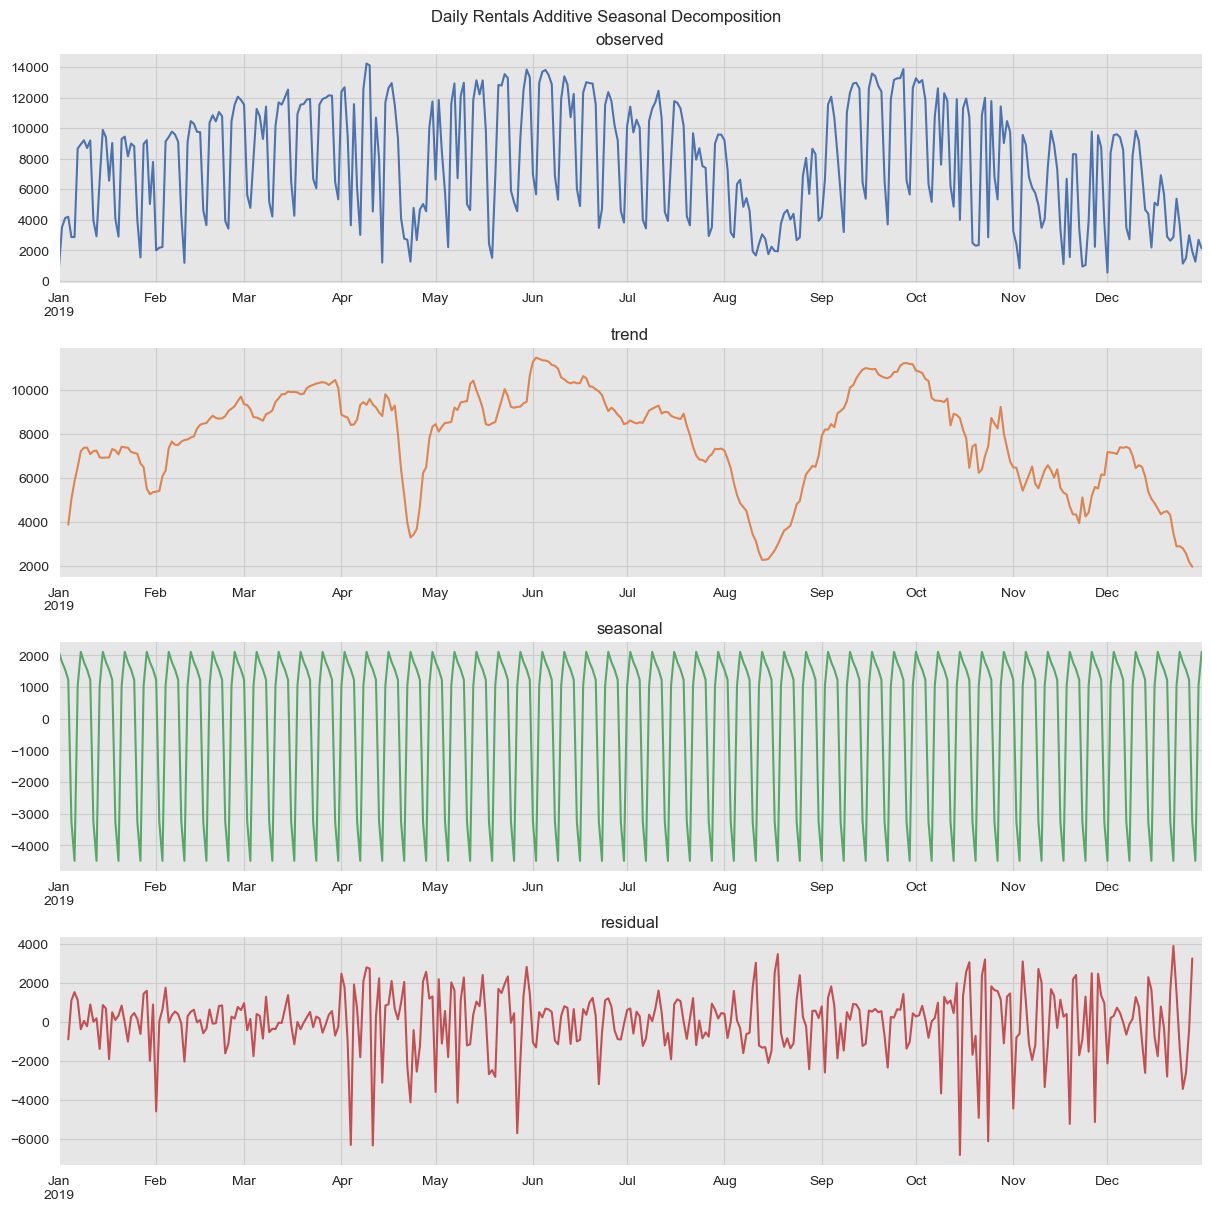

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

weekly_seasonal_decomposition = seasonal_decompose(
    x=daily_outflow["count"],
    model="additive",
    period=7
)

pd.options.plotting.backend = "matplotlib"
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

weekly_seasonal_decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title="observed", xlabel="")
weekly_seasonal_decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title="trend", xlabel="")
weekly_seasonal_decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title="seasonal", xlabel="")
weekly_seasonal_decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title="residual", xlabel="")

plt.suptitle("Daily Rentals Additive Seasonal Decomposition")

Just by looking at the residuals we realise that the seasonal component is not filtered out in the most optimal way - the residual variance changes across time. One strategy might be to take logs and see if the residuals become less volatile. Let's see what changes with a multiplicative decomposition:

Text(0.5, 0.98, 'Daily Rentals Multiplicative Seasonal Decomposition')

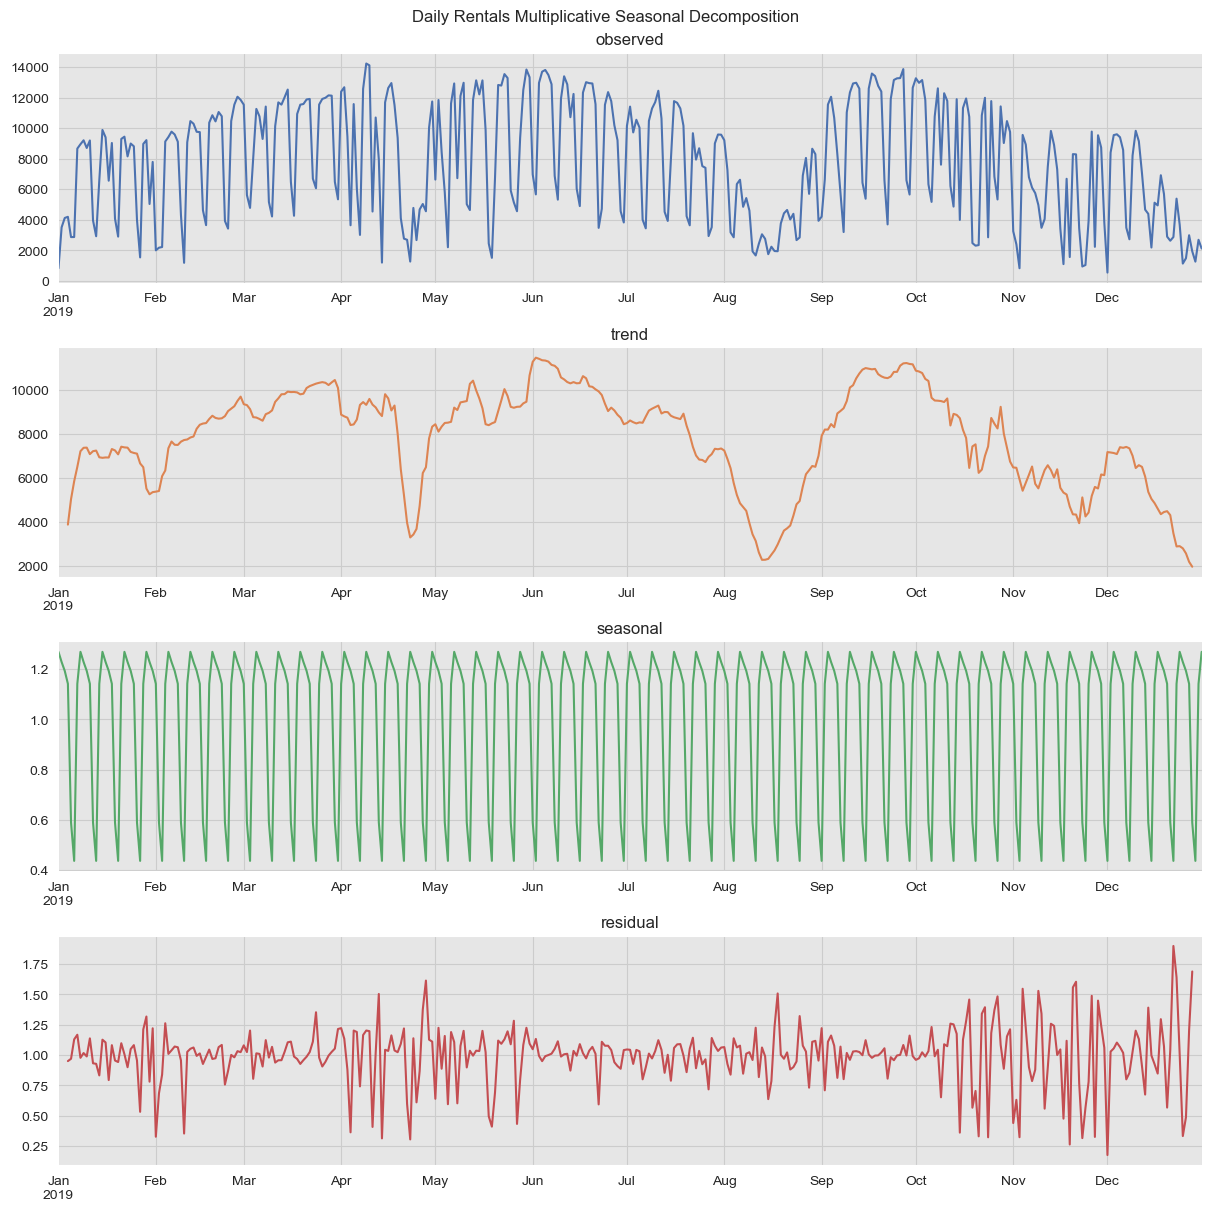

In [15]:
weekly_seasonal_decomposition = seasonal_decompose(
    x=daily_outflow["count"],
    model="multiplicative",
    period=7
)

pd.options.plotting.backend = "matplotlib"
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

weekly_seasonal_decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title="observed", xlabel="")
weekly_seasonal_decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title="trend", xlabel="")
weekly_seasonal_decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title="seasonal", xlabel="")
weekly_seasonal_decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title="residual", xlabel="")

plt.suptitle("Daily Rentals Multiplicative Seasonal Decomposition")

While the first part of the series is slightly better handled, the declining trend in the last part of the year translates into much greater variance towards of the residuals at the end of the year.

# Differencing

In [36]:
pd.options.plotting.backend = "plotly"

## First Differencing

First, let's see how first differencing impacts the data:

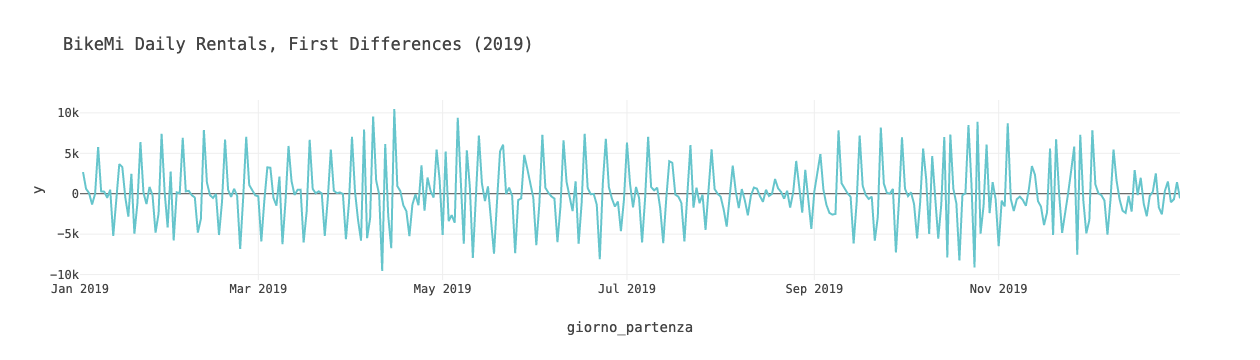

In [9]:
daily_outflow.plot(
    y=daily_outflow["count"].diff(),
    color_discrete_sequence=px.colors.qualitative.Pastel,
    title="BikeMi Daily Rentals, First Differences (2019)",
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

Clearly, taking first differences does not remove the seasonal component - but removes the trend and seemingly returns stationary data. However, as recommended in Hyndman (quote), we need to apply first the seasonal differcing.

First differencing remarks the time-varying nature of the seasonal component of the series, pointing ever more convincingly to an STL decomposition.

## Seasonal Differencing

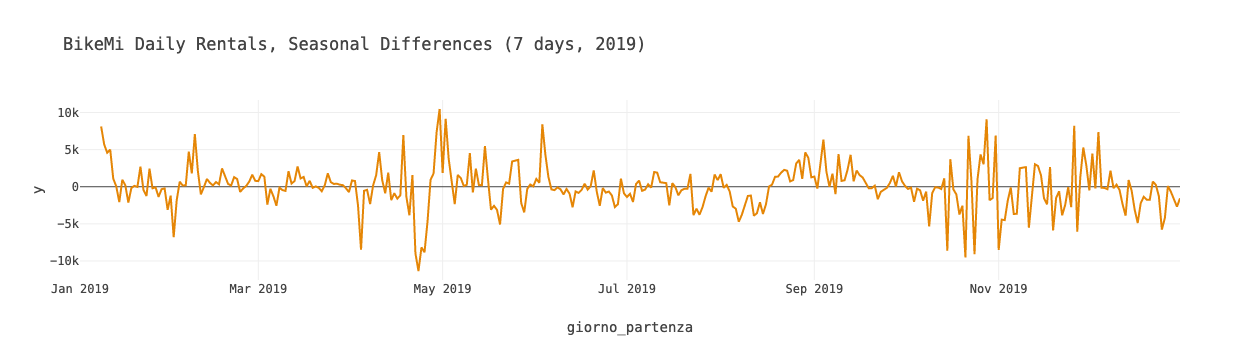

In [31]:
daily_outflow.plot(
    y=daily_outflow["count"].diff(7),
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title="BikeMi Daily Rentals, Seasonal Differences (7 days, 2019)",
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

There is a great variance in the seris: around the end of April, there are consecutive days where there is a difference of ten thousand rentals. At first glance, it seems that seasonal differences do not make the series unequivocally stationary. Let's verify it with a statistical test:

In [21]:
from statsmodels.tsa.stattools import adfuller, kpss

adfuller_results = adfuller(
    # take seasonal diffs and drop the 7 missing values
    daily_outflow["count"].diff(7).dropna(),
    regression="ct"
)

kpss_results = kpss(
    daily_outflow["count"].diff(7).dropna(),
    regression="ct", nlags="auto"
)


console.print(
    f"""
Advanced Dickey-Fuller p-value is {adfuller_results[1]:.2%}: {"there is a unit root - i.e. the series is non-stationary"
    if adfuller_results[1] < 0.05 else "there is no unit root - the series is stationary"}.
KPSS p-value is {kpss_results[1]:.2%}: {"the series is stationary (there is no unit root)"
    if kpss_results[1] > 0.05 else "the series is non-stationary (there is a unit root)"}
    """
)

/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Advanced Dickey-Fuller p-value is 0.13%: there is a unit root - i.e. the series is 
non-stationary.
KPSS p-value is 10.00%: the series is stationary (there is no unit root)

`statsmodels` guide summarises the ADFuller test in this way:

> The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

The presence of a unit root signifies a non-stationary time series. The p-value is much smaller than 5%, so we can safely reject the null hypothesis: there is no unit root, i.e. the series is stationary.

THe Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests for the null hypothesis that a time series $x$ is level or trend stationary. In other words, we want the p-value to be greater than 5%: in this way, we fail to reject the null hypothesis and we can assume it is trend stationary.

`statsmodels` warns us that the test statistics is actually outside of the range of p-values available in the statistical table - this means that the p-value is greater than ten percent. This means we fail to reject the null and that our series is stationary.

However, we might not be satisfied with this - let's have a look at the double differences.

## Double Differences

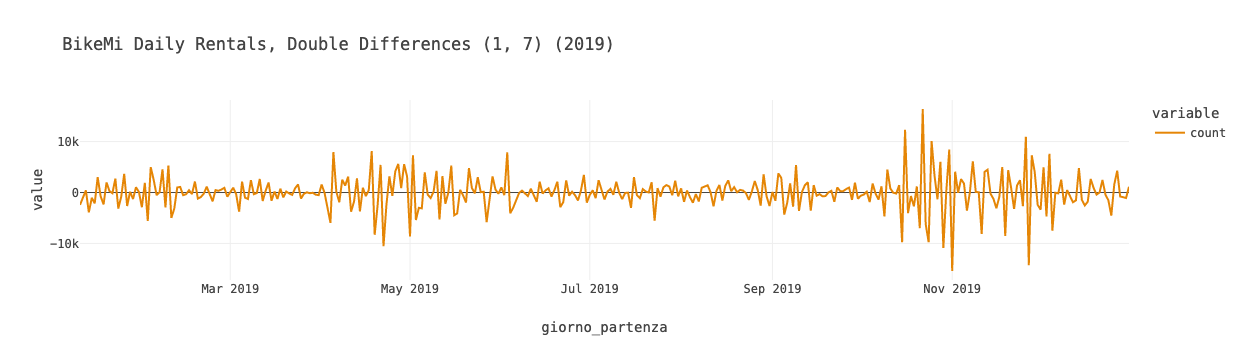

In [37]:
(
    daily_outflow
    .diff(1).diff(7).dropna() # remove missing values created by differencing
    .plot(
        color_discrete_sequence=px.colors.qualitative.Vivid,
        title="BikeMi Daily Rentals, Double Differences (1, 7) (2019)",
    )
    .update_layout(**plotly_styles)
    .update_traces(hovertemplate=None)
)


The series is more convincingly stationary, but still displays a large variance. We can see what happens if we take logs:

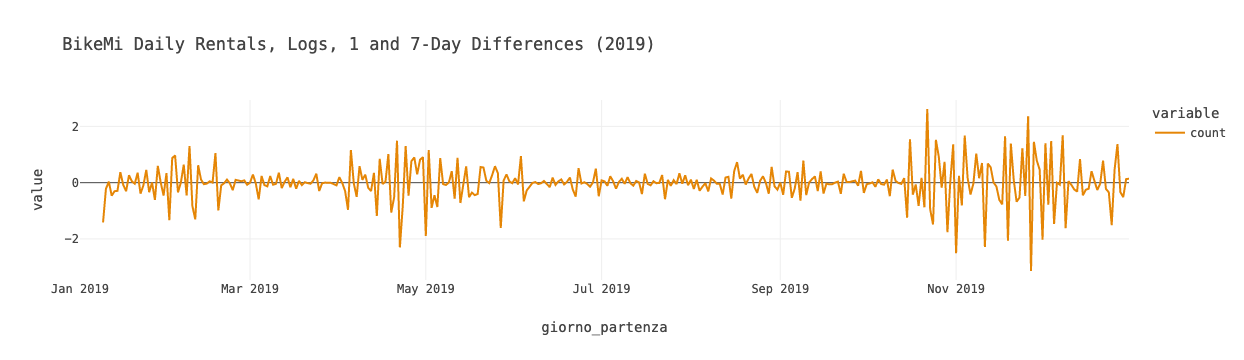

In [40]:
(
    daily_outflow
    .apply(np.log)
    .diff().diff(7)
    .plot(
        color_discrete_sequence=px.colors.qualitative.Vivid,
        title="BikeMi Daily Rentals, Logs, 1 and 7-Day Differences (2019)",
    )
    .update_layout(**plotly_styles)
    .update_traces(hovertemplate=None)
)

This transformation removes stationarity and seasonality, but does not really deal with the variance in the data. We can use our human knowledge to explain some of this variation: holidays, first of all. Then we would expect the temperature to play a role, in conjunction with precipitation (i.e. the winter), which could explain the greater variance around the last months of the year.

This suggests that even a SARIMA model might not compete with something like Prophet, which can exploit holiday patterns and models piecewise trends. However, without the aid of external data, neither of the two models can take into account rainy days or colder weather - even via categorical variables such as dummies for each month. A ETS model could also exploit these patterns.

# Autocorrelation and Partial Autocorrelation Plots

To complement the differencing, let's have a look at the autocorrelation functions.

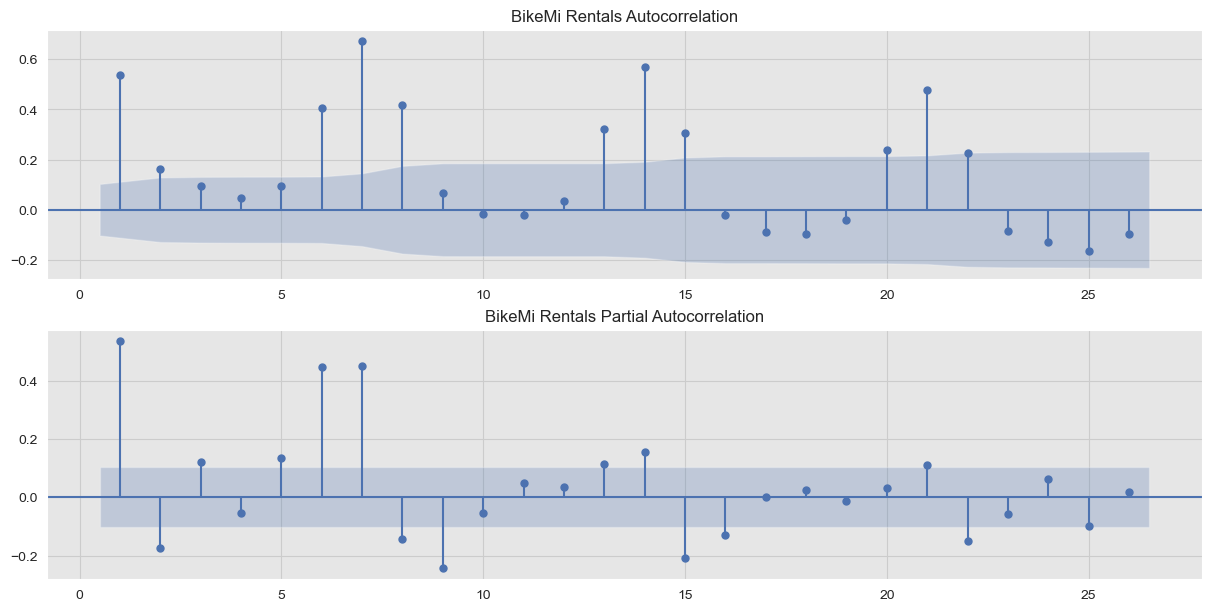

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, constrained_layout=True)
plot_acf(
    x=daily_outflow["count"],
    ax=ax[0],
    title="BikeMi Rentals Autocorrelation",
    zero=False,
)
plot_pacf(
    x=daily_outflow["count"],
    ax=ax[1],
    title="BikeMi Rentals Partial Autocorrelation",
    zero=False,
);

The autocorrelation plot shows a sinusoidal dependence with past lags; the first (and second) lags are significant, and so do the multiples of 7, even beyond the 30th lag. This fact should not be too surprising: we could already spot it from the 30 day window moving average, but is still remarkable. This will likely entail a greater MA component for our (S)ARIMA models; in particular, the ACF suggests a moving average component with 1-2 lags and possibly even more seasonal lags. The partial autocorrelation function indicates an autoregressive component of 1 and a seasonal AR component of perhaps 1 lag. 
